In [155]:
import numpy as np
from numpy.linalg import solve
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy import optimize
from scipy.optimize import minimize_scalar
import egrss 
import lambda_fun
import os 
import scipy.stats
import matplotlib.patches as mpatches


a,b = -0.2, 0.5
n = 100
p = 2
xi = (b-a) ** (2 * p - 1) 
x = np.linspace(a,b,n)
nu = 1 / (0.1 ** 2)

def y(x):
        return 0.25*np.cos(4*np.pi *x) + 0.15*np.sin(12* np.pi *x) + 0.2 * x

yhat = y(x) +  np.random.normal(loc = 0, scale = 0.1, size = x.shape)

def smoothing_spline_reg(y,Ut,Vt,Wt,eps,nu,tau,perturb = None):
    # compute factorization
    d    =   tau / nu
    Zt,c = egrss.potrf(Ut,Vt,d)
    
    # compute rhs
    if perturb is not None: 
        # perturbation of rhs
        n,  = y.shape
        xiy = np.random.normal(loc=0, scale=1, size= n)
        xix = np.random.normal(loc=0, scale=1, size= n)       
        rhs = egrss.symv(Utilde,Vtilde,y+ np.sqrt(nu) / nu * xiy) + np.sqrt(tau) / nu * egrss.trmv(Utilde, Wtilde, xix, c = eps, trans = 'N')
        
    else:
        rhs = egrss.symv(Utilde,Vtilde,y)
        
    # solve LL'x = rhs    
    Ltrhs= egrss.trsv(Ut,Zt,rhs,c,'N')
    x    = egrss.trsv(Ut,Zt,Ltrhs,c,'T')
        
    return x

def plims(x,p = None):
    # computes the emperical quantiles 
    # m is number of samples
    # n is number of parameters
    
    m,n = x.shape
    
    if p is None: 
        p = np.array([0.025, 0.975])
    k, = p.shape
    y = np.zeros((k,n))
    for i in range(n):
        y[:,i] = np.interp((m-1)*p,range(m),np.sort(x[:,i])) 
    
    return y

### Gibbs sampler - we aim to sample from the joint posterior pi(v,u,sigma,nuda,tau|y) 
# See posteriors derived in overleaf
### Gibbs sampler - we aim to sample from the joint posterior pi(v,u,sigma,lambda,delta|y) 
# See posteriors derived in overleaf
nsamps = 10000
s      = 2

# Initialization and memory allocation
del_samp   = np.zeros(nsamps)
tau_samp   = np.zeros(nsamps)
gam_samp   = np.zeros(nsamps)
z_samp     = np.zeros((n,nsamps))
bet_samp   = np.zeros((s,nsamps))
y_samp     = np.zeros((n,nsamps))

# pre-compute matrices and matrix-vector products
Ft, Vt = egrss.generators((t-a)/(b-a),s)       
Wt,eps   = egrss.potrf(Ft,Vt,1e-10) # regularizes the factorization

# initializations
Fb       = Ft.T @ bet_samp[:,0]
residual = np.zeros((n,))



import time
nsamps = 5000
K      = 2 # equvalent to degree of spline

alph   = 1e+3



# pre-compute matrices and matrix-vector products
Ut, Vt = egrss.generators((x-a)/(b-a),K)

Utilde = Ut
Vtilde = Vt + alph * Ut
Wtilde,eps = egrss.potrf(Utilde,Vtilde,1e-10)

residual = yhat-x_samp[:,0]

J = 10

burnin   = int(nsamps/2) 

nu_res   = np.zeros([J, burnin])
tau_res   = np.zeros([J, burnin])
x_res      = np.zeros([J,n , burnin])

nu_mean = np.zeros(J)
tau_mean = np.zeros(J)
x_mean   = np.zeros([J, n])

nu_ci  = np.zeros([J, 2, n])
tau_ci  = np.zeros([J, 2, n])
x_ci     = np.zeros([J, 2, n])


for j in range(J):
    
    # Initialization and memory allocation
    nu_samp   = np.zeros(nsamps)
    tau_samp   = np.zeros(nsamps)
    x_samp      = np.zeros((n,nsamps))

    for i in range(nsamps-1):      
        # sample hyperparameters nuda and nu (taua and alpha)
        # (1a) sample nuda    
        a0,b0    = 1.0 + n / 2, 1e-4 + 0.5 * np.dot(residual,residual)
        nu_samp[i+1] =  np.random.gamma(shape=a0, scale=1/b0)

        # (1b) sample taua
        Linvx = egrss.trsv(Utilde,Wtilde,x_samp[:,i],eps,'N')
        a1,b1    = 1.0 + n / 2, (10**(j+1) + 0.5 * np.dot(Linvx,Linvx)) # 1e+4
        tau_samp[i+1] = np.random.gamma(shape=a1, scale=1/b1)

        # 2a) Compute posterior
        x_samp[:,i+1] = smoothing_spline_reg(yhat,Utilde,Vtilde,Wtilde,eps,nu_samp[i+1],tau_samp[i+1],perturb = 1)

        residual = yhat-x_samp[:,i+1]

    ## Sample statistics 
    # Remove burn-in phase 
    burnin   = int(nu_samp.size/ 2) 
    x_res[j, :, :]    = x_samp[:,burnin:]
    nu_res[j, :] = nu_samp[burnin:]
    tau_res[j, :] = tau_samp[burnin:]

    # Reshape results for statistical functions 
    tau_reshape = tau_res[j, :]
    nu_reshape = nu_res[j, :]
    
    tau_reshape.shape=(nsamps-burnin,1)
    nu_reshape.shape=(nsamps-burnin,1)

    # Compute posterior mean 
    nu_mean[j] = np.mean(nu_reshape,0)
    tau_mean[j] = np.mean(tau_reshape,0)
    x_mean[j, :]    = np.mean(x_res[j, :, :],1)

    # Compute 95% CI 
    nu_ci[j, :, :]  = plims(nu_reshape)
    tau_ci[j, :,:]   = plims(tau_reshape)
    x_ci[j, :, :]      = plims(x_res[j, :, :].T)

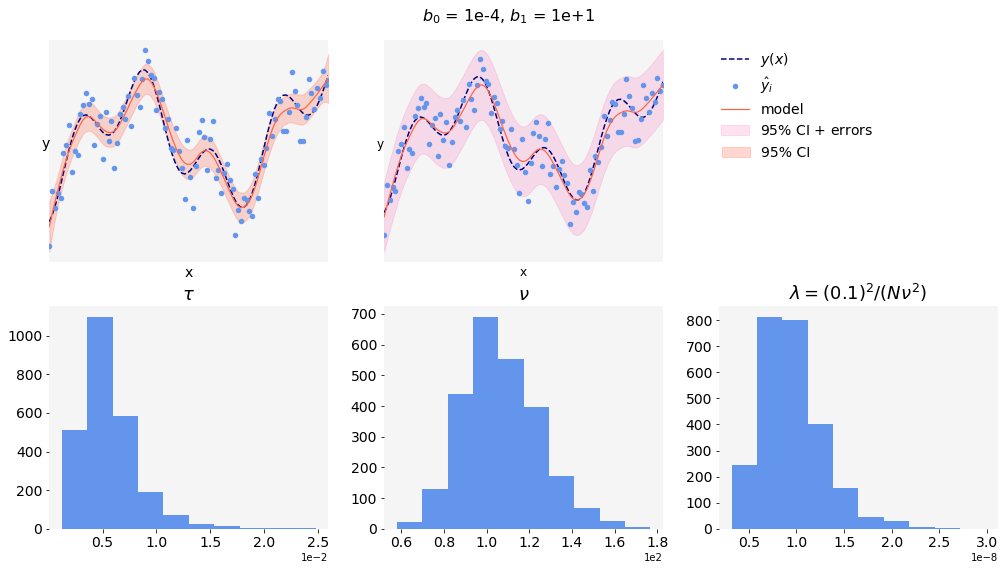

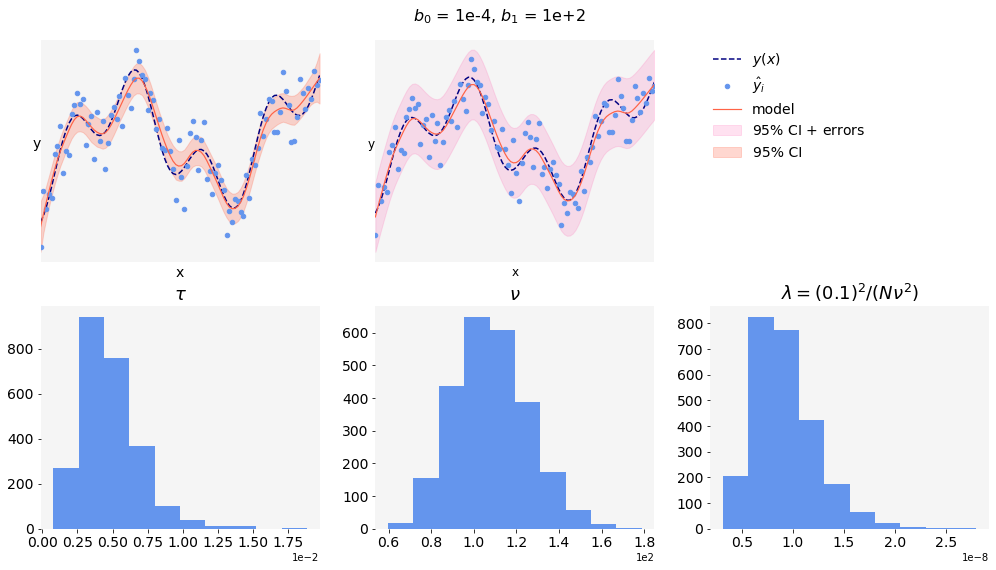

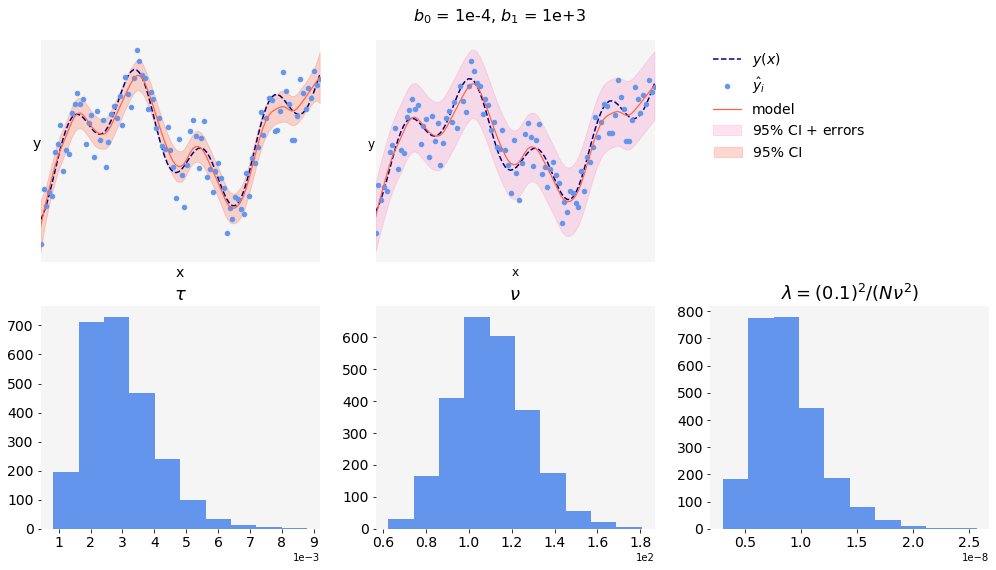

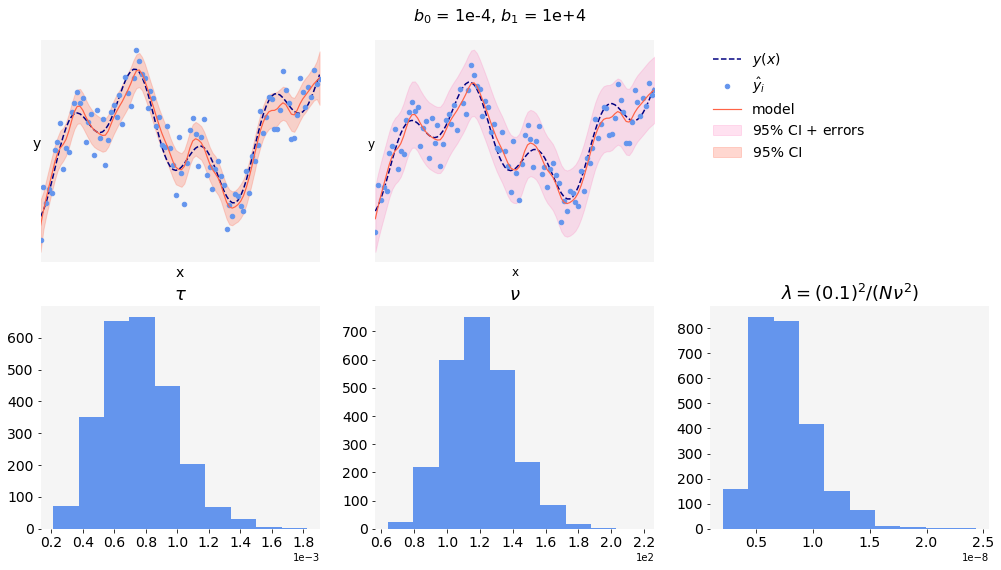

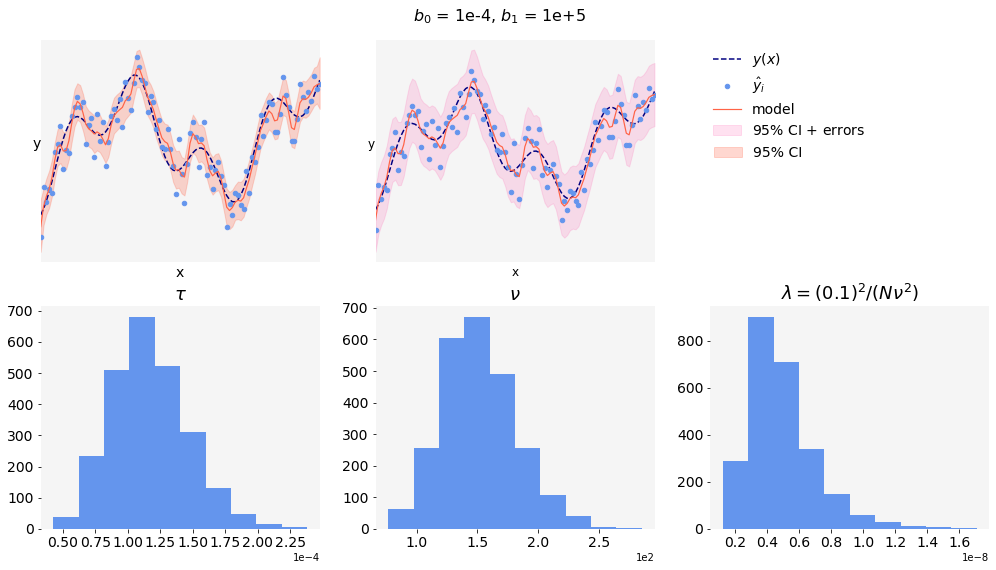

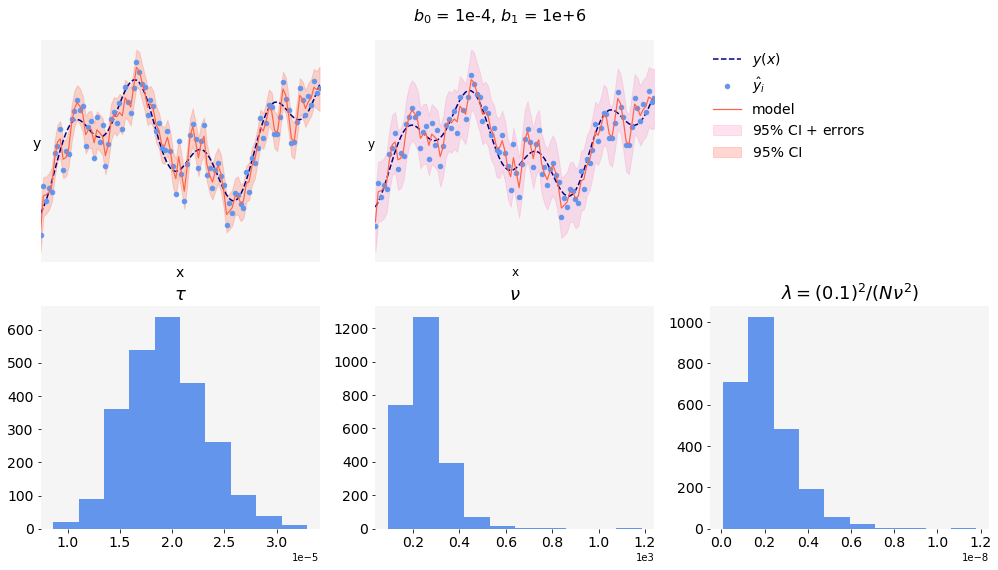

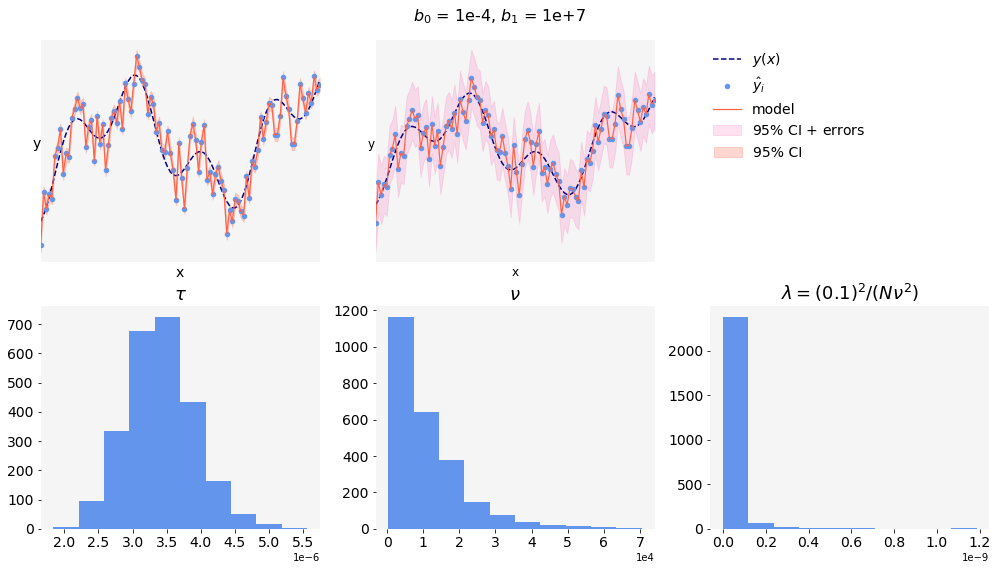

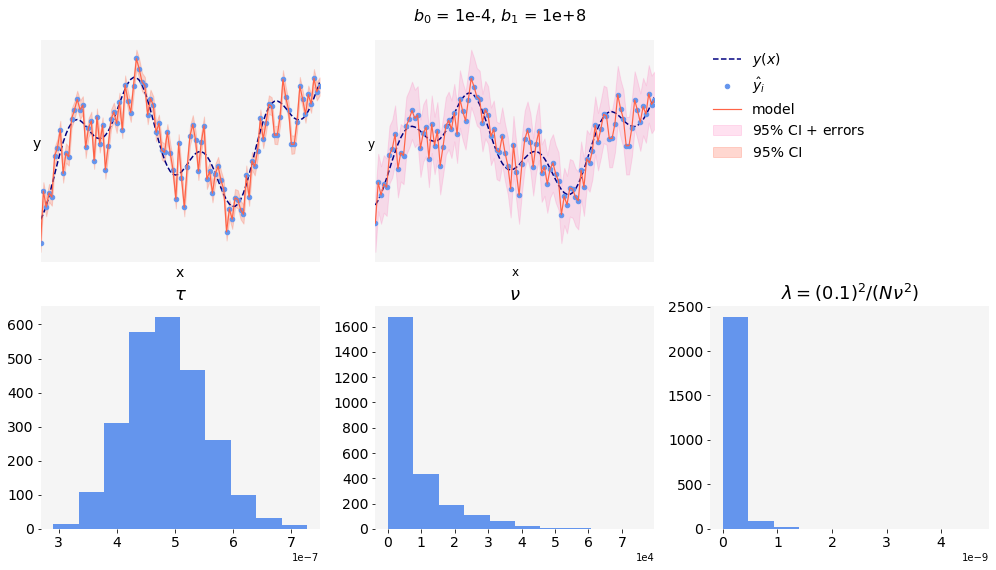

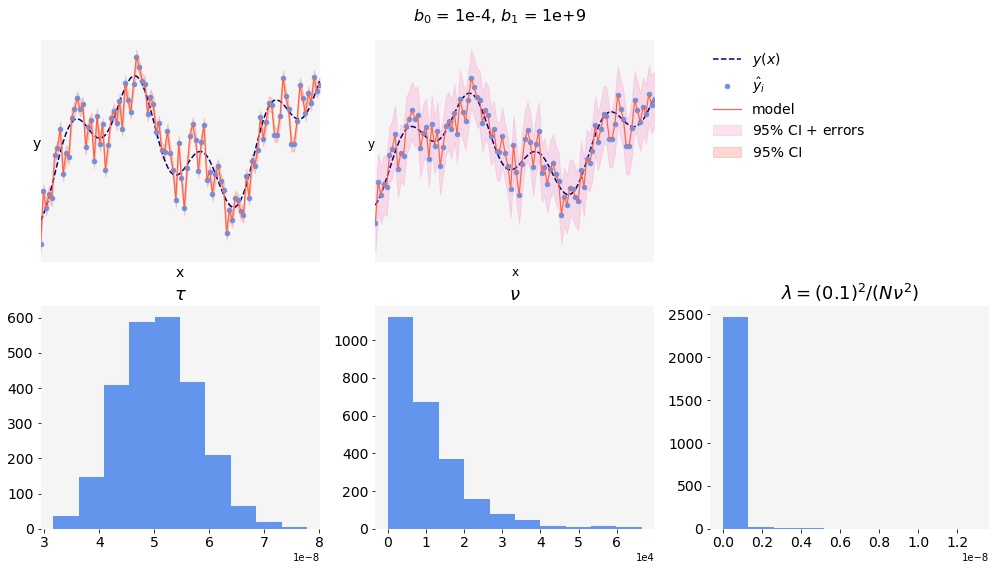

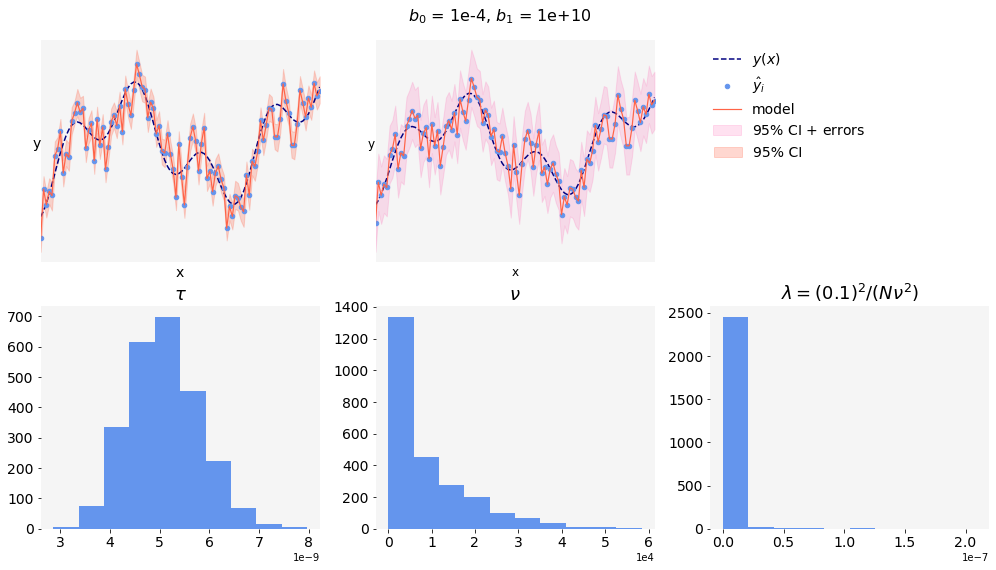

In [173]:
fs = 18
ts = 14
col1 = 'cornflowerblue'
for j in range(J):
    fig = plt.figure()
    plt.subplot(2,3,1)
    plt.plot(x,y(x),'--',color = 'navy', linewidth=1.5, label = '$y(x)$')
    plt.plot(x,yhat,'bo',markersize = 4.5, color = 'cornflowerblue', label = '$\hat{y}_i$')
    plt.plot(x,x_mean[j,:] ,color = 'tomato', linewidth=1.2, label = 'model')
    plt.fill_between(x,x_ci[j,0,:],x_ci[j,1,:], color='tomato', alpha=.25,label = '$95\%$ CI')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('x',  fontsize = ts)
    plt.ylabel('y', rotation = 0, fontsize = ts)
    plt.xlim([a,b])
    plt.tick_params(left=True, bottom = False, right = False, top = False)
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    
    plt.subplot(2,3,2)
    plt.plot(x,y(x),'--',color = 'navy', linewidth=1.5, label = '$y(x)$')
    plt.plot(x,yhat,'bo',markersize = 4.5, color = 'cornflowerblue', label = '$\hat{y}_i$')
    plt.plot(x,x_mean[j,:] ,color = 'tomato', linewidth=1.2, label = 'model')
    plt.fill_between(x,x_mean[j,:]- 0.1*scipy.stats.norm.ppf(0.975),x_mean[j,:]+ 0.1*scipy.stats.norm.ppf(0.975), color='hotpink', alpha=.2,label = '$95\%$ CI + errors')
    red_patch = mpatches.Patch(color='tomato', alpha = .25, label='95% CI')
    fig.legend(handles=[red_patch], bbox_to_anchor=(0.754, 0.705),  loc="center right", borderaxespad=0.2,prop = {'size': 14}, frameon = False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('x',  fontsize = 12)
    plt.ylabel('y',  rotation = 0, fontsize = 12)
    plt.xlim([a,b])
    plt.tick_params(left=True, bottom = False, right = False, top = False)
    plt.legend(numpoints = 1, prop = {'size': 14}, loc = 'lower right',  bbox_to_anchor=(1.8, b), frameon = False)
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)


    plt.subplot(2,3,4)
    plt.hist(tau_res[j,:], color = col1)
    plt.ticklabel_format(axis = 'x', style = 'sci', scilimits=(0,0))
    plt.title('$\\tau$', fontsize = fs)
    plt.xticks(fontsize = ts)
    plt.yticks(fontsize = ts)
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.subplot(2,3,5)
    plt.hist(nu_res[j,:], color = col1)
    plt.title('$\\nu$', fontsize = fs)
    plt.ticklabel_format(axis = 'x', style = 'sci', scilimits=(0,0))
    plt.xticks(fontsize = ts)
    plt.yticks(fontsize = ts)
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.subplot(2,3,6)
    plt.hist((0.1)**2/(n*nu_res[j,:]**2), color = col1)
    plt.title('$\lambda = (0.1)^2 / (N \\nu ^2)$', fontsize = fs)
    plt.xticks(fontsize = ts)
    plt.yticks(fontsize = ts)
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    fig.set_figheight(9)
    fig.set_figwidth(17)
    
    fig.suptitle('$b_0$ = 1e-4, $b_1$ = 1e+%s' %(j+1), y= 0.93,fontsize=16)

    plt.show()

    my_path = os.getcwd()
    fig.savefig(my_path + '/Plots/sampling_res' + str(j+1) + '.pdf', bbox_inches='tight')



2500

(2, 2500)